# Number of Visits for Deep Drilling Field

In [1]:
# Check the version of MAF - the output should be version 2.4.2 or higher.
# 'unknown' means you're running from a git repo version,
# and have made changes to your local code

import lsst.sims.maf
lsst.sims.maf.__version__

'2.13.0.sims-59-g0a27faef'

In [81]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import healpy as hp

In [4]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

from lsst.sims.maf.db import ResultsDb

In [5]:
import sys
print(sys.path)

['/Users/dagoret/MacOSX/GitHub/LSST/MyCadence/NumberOfVisits', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/obs_lsst/19.0.0-80-g0bd2bb3+1/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/ts_dateloc/master-g60a36c8d46+46/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/ts_observatory_model/master-g3d307a5f45+46/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_almanac/master-g021b69e146+1/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_downtimeModel/master-g55f72efa65+17/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_cloudModel/master-ge3724df529+19/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_si

### Specify my other python path (my installation)

In [6]:
otherpythonpaths=['/Users/dagoret/anaconda3/lib/python37.zip', '/Users/dagoret/anaconda3/lib/python3.7', '/Users/dagoret/anaconda3/lib/python3.7/lib-dynload', '', '/Users/dagoret/.local/lib/python3.7/site-packages', '/Users/dagoret/anaconda3/lib/python3.7/site-packages', '/Users/dagoret/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/dagoret/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/dagoret/.ipython']

In [7]:
for thepath in otherpythonpaths:
    sys.path.append(thepath) # go to parent dir

In [8]:
import healpy as hp

In [9]:
%load_ext autoreload
%autoreload 2

# Config

In [10]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
colors = {'u': 'cyan', 'g': 'g', 'r': 'y','i': 'r', 'z': 'm', 'y': 'k'}
Nfilt=len(filters)

In [11]:
nyears=10
maxnights=365.25*nyears

In [12]:
all_sqlconstraint=[]
all_bundlename=[]
for f in filters:
    sqlconstraint = "filter = \'{}\' and night< {}".format(f,maxnights)
    bundlename    = 'bundSBN_{}'.format(f) 
    all_bundlename.append(bundlename)
    all_sqlconstraint.append(sqlconstraint)
    

In [13]:
all_sqlconstraint

["filter = 'u' and night< 3652.5",
 "filter = 'g' and night< 3652.5",
 "filter = 'r' and night< 3652.5",
 "filter = 'i' and night< 3652.5",
 "filter = 'z' and night< 3652.5",
 "filter = 'y' and night< 3652.5"]

In [14]:
all_bundlename

['bundSBN_u', 'bundSBN_g', 'bundSBN_r', 'bundSBN_i', 'bundSBN_z', 'bundSBN_y']

# Simu data

In [15]:
# Note the V3 for opening opsim version 3.x databases.
# Use V4 for more recent runs.

#opsdb = db.OpsimDatabase('baseline2018a.db')
opsdb = db.OpsimDatabase('/Users/dagoret/DATA/Cadence/baseline2018a.db')
outDir = 'output_numberofvisits'
resultsDb = db.ResultsDb(outDir=outDir)

# Metrics

In [16]:
# metric = the "maximum" of the "skybrightness" for each group of visits in the slicer
metric = metrics.CountMetric(col='observationStartMJD')

summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(),
                  metrics.MaxMetric(), metrics.RmsMetric()]


# Slicer

In [17]:
nside=128
#slicer = slicers.HealpixSlicer(nside=nside)
slicer = slicers.OpsimFieldSlicer()

In [18]:
hp.nside2npix(nside)

196608

In [19]:
hp.nside2resol(nside,arcmin=True)

27.483891294539248

# Bundle

- Bundles dict for all filter

In [20]:
#plotDict = {'colorMax': 75}
#plotDict = {'colorMin':0, 'colorMax': 40 , 'cbarFormat': '%0.2f'}
# only plot the sky maps for now
#plotFuncs = [plots.HealpixSkyMap()]

In [21]:
bundles = {}
for ifilt in np.arange(Nfilt):
    sqlconstraint = all_sqlconstraint[ifilt]
    bundlename    = all_bundlename[ifilt]
    bundles[bundlename] = metricBundles.MetricBundle(metric, slicer, sqlconstraint,summaryMetrics=summaryMetrics)
    print(bundles[bundlename].dbCols)

{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}
{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}
{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}
{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}
{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}
{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}


In [22]:
bgroup = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outDir,resultsDb=resultsDb)

Querying database SummaryAllProps with constraint filter = 'y' and night< 3652.5 for columns ['fieldDec', 'observationStartMJD', 'fieldRA', 'fieldId']
Found 445157 visits
Running:  ['bundSBN_y']
Completed metric generation.
Running reduce methods.
Running summary statistics.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:97: UserWarning: Warning: this OpsimFieldSlicer was already set up once. Re-setting up an OpsimFieldSlicer can change the field information. Rerun metrics if this was intentional. 
  warnings.warn(warning_msg)


Completed.
Querying database SummaryAllProps with constraint filter = 'u' and night< 3652.5 for columns ['fieldDec', 'observationStartMJD', 'fieldRA', 'fieldId']
Found 177538 visits
Running:  ['bundSBN_u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'z' and night< 3652.5 for columns ['fieldDec', 'observationStartMJD', 'fieldRA', 'fieldId']
Found 486208 visits
Running:  ['bundSBN_z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'g' and night< 3652.5 for columns ['fieldDec', 'observationStartMJD', 'fieldRA', 'fieldId']
Found 234144 visits
Running:  ['bundSBN_g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'r' and night< 3652.5 for columns ['fieldDec', 'observationStartMJD',

/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 2465 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Plotting figures with "filter = 'u' and night< 3652.5" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 8673 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Plotting figures with "filter = 'z' and night< 3652.5" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 387 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Plotting figures with "filter = 'g' and night< 3652.5" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 310 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Plotting figures with "filter = 'r' and night< 3652.5" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 267 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Plotting figures with "filter = 'i' and night< 3652.5" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 275 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


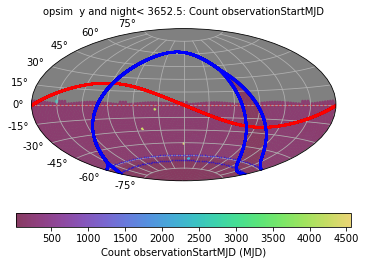

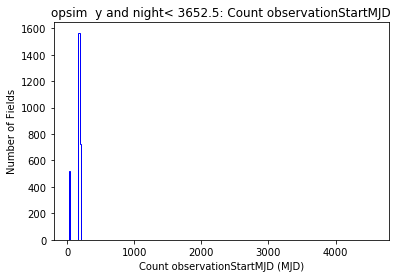

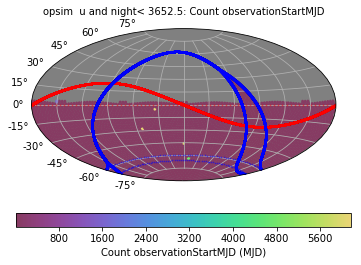

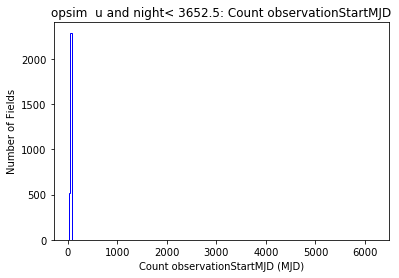

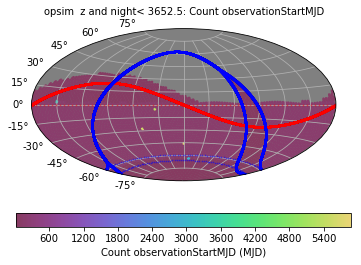

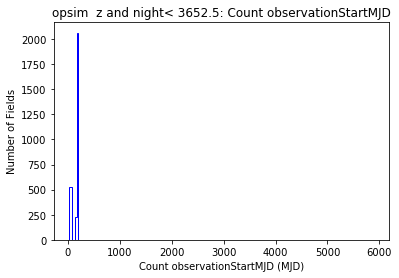

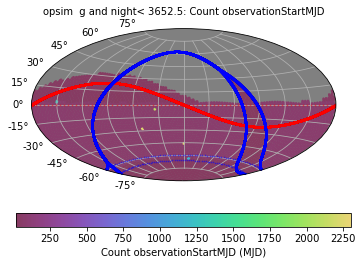

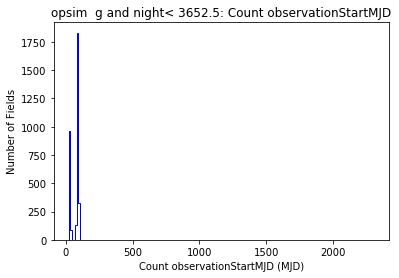

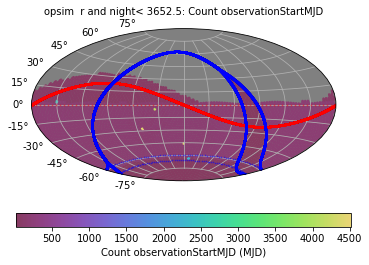

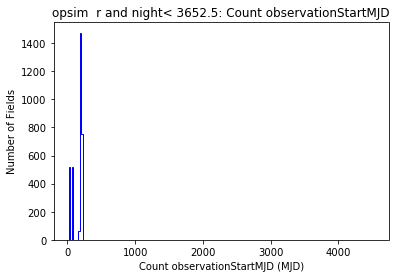

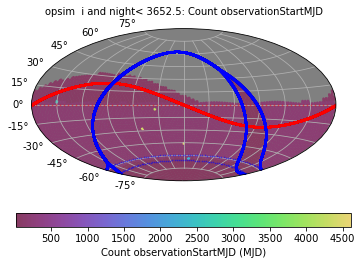

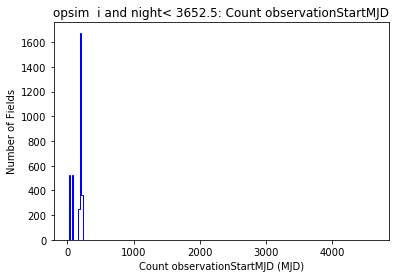

In [23]:
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [24]:
for ifilt in np.arange(Nfilt):
    
    bundlename    = all_bundlename[ifilt]

    print("===============================",filters[ifilt],"===============================")
    print(bundles[bundlename].dbCols)
    print(len(bundles[bundlename].metricValues))
    print(bundles[bundlename].metricValues[0:1000])
    print(bundles[bundlename].summaryValues)
    

=============================== u ===============================
{'observationStartMJD', 'fieldRA', 'fieldDec', 'fieldId'}
3342
[26.0 27.0 27.0 25.0 27.0 25.0 27.0 26.0 26.0 27.0 25.0 27.0 25.0 27.0
 27.0 25.0 27.0 26.0 27.0 25.0 26.0 26.0 27.0 26.0 27.0 25.0 27.0 27.0
 25.0 27.0 25.0 27.0 26.0 26.0 27.0 25.0 27.0 25.0 27.0 26.0 27.0 26.0
 27.0 26.0 27.0 25.0 27.0 27.0 25.0 27.0 25.0 27.0 25.0 27.0 25.0 27.0
 26.0 26.0 26.0 27.0 26.0 27.0 25.0 27.0 25.0 27.0 26.0 27.0 27.0 27.0
 26.0 27.0 27.0 25.0 27.0 25.0 27.0 26.0 26.0 27.0 25.0 27.0 26.0 26.0
 26.0 27.0 26.0 27.0 25.0 27.0 25.0 26.0 27.0 27.0 25.0 27.0 26.0 27.0
 25.0 27.0 26.0 26.0 27.0 25.0 27.0 25.0 27.0 26.0 27.0 25.0 27.0 26.0
 26.0 26.0 27.0 25.0 27.0 26.0 27.0 26.0 27.0 25.0 26.0 26.0 27.0 25.0
 27.0 26.0 27.0 25.0 27.0 25.0 26.0 27.0 27.0 25.0 27.0 25.0 27.0 26.0
 26.0 26.0 27.0 25.0 27.0 25.0 27.0 25.0 27.0 25.0 27.0 26.0 26.0 26.0
 27.0 26.0 27.0 27.0 27.0 26.0 27.0 26.0 27.0 25.0 27.0 25.0 27.0 26.0
 27.0 25.0 27.0 25.

=============================== u ===============================
[ 289  743 1426 2411 2782]
=============================== g ===============================
[ 289  743 1426 2411 2782]
=============================== r ===============================
[ 289  743 1426 2411 2782]
=============================== i ===============================
[ 289  743 1426 2411 2782]
=============================== z ===============================
[ 289  743 1426 2411 2782]
=============================== y ===============================
[ 289  743 1426 2411 2782]


Text(0.5, 0, 'Field number')

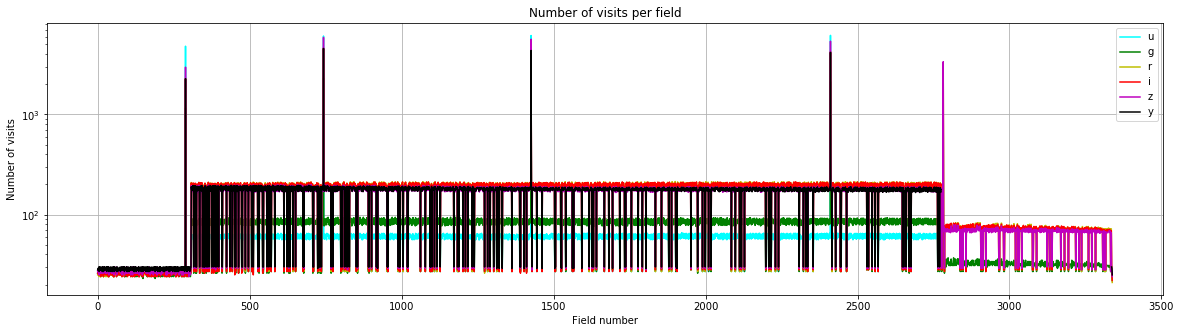

In [25]:
plt.figure(figsize=(20,5))
all_ddf = []
for ifilt in np.arange(Nfilt):
    print("===============================",filters[ifilt],"===============================")
    bundlename    = all_bundlename[ifilt]
    NumberOfVisits=bundles[bundlename].metricValues
    ddf=np.where(NumberOfVisits>1000)[0]
    all_ddf.append(ddf)
    print(ddf)
    
    plt.plot(NumberOfVisits,color=colors[filters[ifilt]],label=filters[ifilt])
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Number of visits per field')
plt.ylabel('Number of visits')
plt.xlabel('Field number')   

# The drilling fields

In [55]:
ddf_id=[ 289, 743 , 1426 , 2411 , 2782]
NDDF=len(ddf_id)
ddf_ra=np.zeros(NDDF)
ddf_dec=np.zeros(NDDF)

In [56]:
metric = metrics.PassMetric(cols=['fieldRA','fieldDec','fieldId','observationStartMJD','fiveSigmaDepth'])

In [57]:
slicer=slicers.opsimFieldSlicer.OpsimFieldSlicer()

In [58]:
bundles = {}
for ifilt in np.arange(Nfilt):
    sqlconstraint = all_sqlconstraint[ifilt]
    bundlename    = all_bundlename[ifilt]
    bundles[bundlename] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    print(bundles[bundlename].dbCols)

{'fieldRA', 'fiveSigmaDepth', 'fieldId', 'observationStartMJD', 'fieldDec'}
{'fieldRA', 'fiveSigmaDepth', 'fieldId', 'observationStartMJD', 'fieldDec'}
{'fieldRA', 'fiveSigmaDepth', 'fieldId', 'observationStartMJD', 'fieldDec'}
{'fieldRA', 'fiveSigmaDepth', 'fieldId', 'observationStartMJD', 'fieldDec'}
{'fieldRA', 'fiveSigmaDepth', 'fieldId', 'observationStartMJD', 'fieldDec'}
{'fieldRA', 'fiveSigmaDepth', 'fieldId', 'observationStartMJD', 'fieldDec'}


In [59]:
bgroup = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outDir,resultsDb=resultsDb)

In [60]:
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = 'y' and night< 3652.5 for columns ['fiveSigmaDepth', 'fieldRA', 'fieldId', 'observationStartMJD', 'fieldDec']
Found 445157 visits
Running:  ['bundSBN_y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'u' and night< 3652.5 for columns ['fiveSigmaDepth', 'fieldRA', 'fieldId', 'observationStartMJD', 'fieldDec']
Found 177538 visits
Running:  ['bundSBN_u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'z' and night< 3652.5 for columns ['fiveSigmaDepth', 'fieldRA', 'fieldId', 'observationStartMJD', 'fieldDec']
Found 486208 visits
Running:  ['bundSBN_z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'g' and night< 3652.5 for 

In [61]:
idx=0

In [62]:
ddf0=ddf_id[0]
ddf0

289

In [63]:
#plt.figure(figsize=(16,5))
all_Ra=[]
all_Dec=[]
for ifilt in np.arange(Nfilt):
    bundlename    = all_bundlename[ifilt]
    fieldnames=np.array(bundles[bundlename].metricValues.data[0].dtype.names)
    
    print(fieldnames)
    nfields=len(fieldnames)
    
    idx_fieldDec=np.where(fieldnames=="fieldDec")[0][0]
    idx_fieldRA=np.where(fieldnames=="fieldRA")[0][0]
    idx_observationStartMJD=np.where(fieldnames=="observationStartMJD")[0][0]
    idx_fieldId=np.where(fieldnames=="fieldId")[0][0]
    idx_fiveSigmaDepth=np.where(fieldnames=='fiveSigmaDepth')[0][0]
    print("indexes",idx_fieldDec,idx_fieldRA,idx_observationStartMJD,idx_fieldId,idx_fiveSigmaDepth)
    # select data from the drilling field
    data=bundles[bundlename].metricValues[ddf0]
    ra=data[0][idx_fieldRA]
    dec=data[0][idx_fieldDec]
    print("Ra = ",ra)
    print("Dec = ",dec)
    all_Ra.append(ra)
    all_Dec.append(dec)
    
    nvisits=len(data)
    #data=np.reshape(data.flatten(),(nvisits,nfields))   
    #plt.plot(data[:,idx_observationStartMJD],data[:,idx_fiveSigmaDepth],color=colors[filters[ifilt]],label=filters[ifilt])

['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  349.386443
Dec =  -63.32100400000001
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  349.386443
Dec =  -63.32100400000001
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  349.386443
Dec =  -63.32100400000001
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  349.386443
Dec =  -63.32100400000001
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  349.386443
Dec =  -63.32100400000001
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  349.386443
Dec =  -63.32100400000001


In [64]:
ddf_ra[idx]=ra
ddf_dec[idx]=dec
idx+=1

In [65]:
ddf0=ddf_id[1]
ddf0

743

In [66]:
#plt.figure(figsize=(16,5))
all_Ra=[]
all_Dec=[]
for ifilt in np.arange(Nfilt):
    bundlename    = all_bundlename[ifilt]
    fieldnames=np.array(bundles[bundlename].metricValues.data[0].dtype.names)
    
    print(fieldnames)
    nfields=len(fieldnames)
    
    idx_fieldDec=np.where(fieldnames=="fieldDec")[0][0]
    idx_fieldRA=np.where(fieldnames=="fieldRA")[0][0]
    idx_observationStartMJD=np.where(fieldnames=="observationStartMJD")[0][0]
    idx_fieldId=np.where(fieldnames=="fieldId")[0][0]
    idx_fiveSigmaDepth=np.where(fieldnames=='fiveSigmaDepth')[0][0]
    print("indexes",idx_fieldDec,idx_fieldRA,idx_observationStartMJD,idx_fieldId,idx_fiveSigmaDepth)
    # select data from the drilling field
    data=bundles[bundlename].metricValues[ddf0]
    ra=data[0][idx_fieldRA]
    dec=data[0][idx_fieldDec]
    print("Ra = ",ra)
    print("Dec = ",dec)
    all_Ra.append(ra)
    all_Dec.append(dec)
    
    nvisits=len(data)
    #data=np.reshape(data.flatten(),(nvisits,nfields))   
    #plt.plot(data[:,idx_observationStartMJD],data[:,idx_fiveSigmaDepth],color=colors[filters[ifilt]],label=filters[ifilt])

['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  0.0
Dec =  -45.524505
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  0.0
Dec =  -45.524505
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  0.0
Dec =  -45.524505
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  0.0
Dec =  -45.524505
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  0.0
Dec =  -45.524505
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  0.0
Dec =  -45.524505


In [67]:
ddf_ra[idx]=ra
ddf_dec[idx]=dec
idx+=1

In [68]:
ddf0=ddf_id[2]
ddf0

1426

In [69]:
#plt.figure(figsize=(16,5))
all_Ra=[]
all_Dec=[]
for ifilt in np.arange(Nfilt):
    bundlename    = all_bundlename[ifilt]
    fieldnames=np.array(bundles[bundlename].metricValues.data[0].dtype.names)
    
    print(fieldnames)
    nfields=len(fieldnames)
    
    idx_fieldDec=np.where(fieldnames=="fieldDec")[0][0]
    idx_fieldRA=np.where(fieldnames=="fieldRA")[0][0]
    idx_observationStartMJD=np.where(fieldnames=="observationStartMJD")[0][0]
    idx_fieldId=np.where(fieldnames=="fieldId")[0][0]
    idx_fiveSigmaDepth=np.where(fieldnames=='fiveSigmaDepth')[0][0]
    print("indexes",idx_fieldDec,idx_fieldRA,idx_observationStartMJD,idx_fieldId,idx_fiveSigmaDepth)
    # select data from the drilling field
    data=bundles[bundlename].metricValues[ddf0]
    ra=data[0][idx_fieldRA]
    dec=data[0][idx_fieldDec]
    print("Ra = ",ra)
    print("Dec = ",dec)
    all_Ra.append(ra)
    all_Dec.append(dec)
    
    nvisits=len(data)
    #data=np.reshape(data.flatten(),(nvisits,nfields))   
    #plt.plot(data[:,idx_observationStartMJD],data[:,idx_fiveSigmaDepth],color=colors[filters[ifilt]],label=filters[ifilt])

['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  53.009145
Dec =  -27.438943
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  53.009145
Dec =  -27.438943
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  53.009145
Dec =  -27.438943
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  53.009145
Dec =  -27.438943
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  53.009145
Dec =  -27.438943
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  53.009145
Dec =  -27.438943


In [70]:
ddf_ra[idx]=ra
ddf_dec[idx]=dec
idx+=1

In [71]:
ddf0=ddf_id[3]
ddf0

2411

In [72]:
#plt.figure(figsize=(16,5))
all_Ra=[]
all_Dec=[]
for ifilt in np.arange(Nfilt):
    bundlename    = all_bundlename[ifilt]
    fieldnames=np.array(bundles[bundlename].metricValues.data[0].dtype.names)
    
    print(fieldnames)
    nfields=len(fieldnames)
    
    idx_fieldDec=np.where(fieldnames=="fieldDec")[0][0]
    idx_fieldRA=np.where(fieldnames=="fieldRA")[0][0]
    idx_observationStartMJD=np.where(fieldnames=="observationStartMJD")[0][0]
    idx_fieldId=np.where(fieldnames=="fieldId")[0][0]
    idx_fiveSigmaDepth=np.where(fieldnames=='fiveSigmaDepth')[0][0]
    print("indexes",idx_fieldDec,idx_fieldRA,idx_observationStartMJD,idx_fieldId,idx_fiveSigmaDepth)
    # select data from the drilling field
    data=bundles[bundlename].metricValues[ddf0]
    ra=data[0][idx_fieldRA]
    dec=data[0][idx_fieldDec]
    print("Ra = ",ra)
    print("Dec = ",dec)
    all_Ra.append(ra)
    all_Dec.append(dec)
    
    nvisits=len(data)
    #data=np.reshape(data.flatten(),(nvisits,nfields))   
    #plt.plot(data[:,idx_observationStartMJD],data[:,idx_fiveSigmaDepth],color=colors[filters[ifilt]],label=filters[ifilt])

['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  34.393398
Dec =  -5.09032
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  34.393398
Dec =  -5.09032
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  34.393398
Dec =  -5.09032
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  34.393398
Dec =  -5.09032
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  34.393398
Dec =  -5.09032
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  34.393398
Dec =  -5.09032


In [73]:
ddf_ra[idx]=ra
ddf_dec[idx]=dec
idx+=1

In [74]:
ddf0=ddf_id[4]
ddf0

2782

In [75]:
#plt.figure(figsize=(16,5))
all_Ra=[]
all_Dec=[]
for ifilt in np.arange(Nfilt):
    bundlename    = all_bundlename[ifilt]
    fieldnames=np.array(bundles[bundlename].metricValues.data[0].dtype.names)
    
    print(fieldnames)
    nfields=len(fieldnames)
    
    idx_fieldDec=np.where(fieldnames=="fieldDec")[0][0]
    idx_fieldRA=np.where(fieldnames=="fieldRA")[0][0]
    idx_observationStartMJD=np.where(fieldnames=="observationStartMJD")[0][0]
    idx_fieldId=np.where(fieldnames=="fieldId")[0][0]
    idx_fiveSigmaDepth=np.where(fieldnames=='fiveSigmaDepth')[0][0]
    print("indexes",idx_fieldDec,idx_fieldRA,idx_observationStartMJD,idx_fieldId,idx_fiveSigmaDepth)
    # select data from the drilling field
    data=bundles[bundlename].metricValues[ddf0]
    ra=data[0][idx_fieldRA]
    dec=data[0][idx_fieldDec]
    print("Ra = ",ra)
    print("Dec = ",dec)
    all_Ra.append(ra)
    all_Dec.append(dec)
    
    nvisits=len(data)
    #data=np.reshape(data.flatten(),(nvisits,nfields))   
    #plt.plot(data[:,idx_observationStartMJD],data[:,idx_fiveSigmaDepth],color=colors[filters[ifilt]],label=filters[ifilt])

['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  150.362355
Dec =  2.836499
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  150.362355
Dec =  2.836499
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  150.362355
Dec =  2.836499
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  150.362355
Dec =  2.836499
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  150.362355
Dec =  2.836499
['fiveSigmaDepth' 'fieldRA' 'fieldId' 'observationStartMJD' 'fieldDec']
indexes 4 1 3 2 0
Ra =  150.362355
Dec =  2.836499


In [76]:
ddf_ra[idx]=ra
ddf_dec[idx]=dec
idx+=1

In [77]:
print(ddf_id)

[289, 743, 1426, 2411, 2782]


In [78]:
print(ddf_ra)

[349.386443   0.        53.009145  34.393398 150.362355]


In [79]:
print(ddf_dec)

[-63.321004 -45.524505 -27.438943  -5.09032    2.836499]


In [82]:
df = pd.DataFrame()

In [83]:
df["field_id"] = ddf_id
df['field_ra'] =ddf_ra
df["field_dec"] = ddf_dec

In [85]:
df.style.format({'field_ra': "{:0<3.2f}", 'field_dec': '{:1<3.2f}'})

,field_id,field_ra,field_dec
0,289,349.39,-63.32
1,743,0.00,-45.52
2,1426,53.01,-27.44
3,2411,34.39,-5.09
4,2782,150.36,2.84
